In [ ]:
!pip install numba

In [1]:
import os
from scipy import ndimage
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import pandas as pd
import meshplex
import meshio
import numpy as np
import math
from shapely.geometry import LineString
import stripy as stripy
from scipy import spatial
from netCDF4 import Dataset
from mpl_toolkits.basemap import pyproj
from mpl_toolkits.basemap import Basemap, shiftgrid
import xarray as xr
import pyvista as pv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from gospl._fortran import definegtin, gfill
import sys
sys.path.insert(1, '/Applications/pygplates_rev28_python38_MacOS64')
import pygplates

from numba import jit, njit
import numba

label_size = 7
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=6)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 1- Create global mesh

Define the refinement level to increase resolution.

In [2]:
ref_lvl = 6 # I advise 11 or 12 for local/regional studies
dir_lvl = 'global_data/meshes'
    
if not os.path.exists(dir_lvl):
    os.makedirs(dir_lvl)

Build the mesh

In [3]:
if ref_lvl < 11:
    grid = stripy.spherical_meshes.icosahedral_mesh(include_face_points=False, 
                                                    refinement_levels=ref_lvl)
else:
    grid = stripy.spherical_meshes.octahedral_mesh(include_face_points=False, 
                                                   refinement_levels=ref_lvl)

str_fmt = "{:25} {:9}"

print(str_fmt.format('Number of points', grid.npoints))
print(str_fmt.format('Number of cells', grid.simplices.shape[0]))

Number of points              40962
Number of cells               81920


In [4]:
radius = 6378137.

coords = np.vstack((grid.points[:,0],grid.points[:,1]))
coords = np.vstack((coords,grid.points[:,2])).T
coords = np.multiply(coords,radius)

Define mesh cells and nodes neighbourhood

In [5]:
Gmesh = meshplex.MeshTri(coords, grid.simplices)

In [6]:
s = Gmesh.idx_hierarchy.shape
a = np.sort(Gmesh.idx_hierarchy.reshape(s[0], -1).T)

In [7]:
Gmesh.edges = {"points": np.unique(a, axis=0)}
ngbNbs, ngbID = definegtin(len(coords), Gmesh.cells('points'), Gmesh.edges['points'])

In [8]:
# Create mesh variables
ngbIDs = ngbID[:,:8].astype(int)
vertices = coords.copy()
cells = grid.simplices

# Convert spherical mesh longitudes and latitudes from radian to degree
glat=np.mod(np.degrees(grid.lats)+90, 180.0)
glon=np.mod(np.degrees(grid.lons)+180.0, 360.0)

# 2- Create the initial topography

## Read Etopo01 

In [9]:
# Open etopo
etopo = xr.open_dataset('../1-RefFrame/etopo/ETOPO1_Bed_c_gmt4_0.00Ma.nc')
ztopo = etopo.Band1.values
elev = ndimage.gaussian_filter(ztopo.T,sigma=0.1)

# Map mesh coordinates on this dataset
lon1 = elev.shape[0] * glon / 360.0
lat1 = elev.shape[1] * glat / 180.0
coord1 = np.stack((lon1, lat1))

mesh3D = ndimage.map_coordinates(elev, coord1, order=2, mode='nearest').astype(np.float64)


In [10]:
# Map mesh coordinates on this dataset
lon1 = elev.shape[0] * glon / 360.0
lat1 = elev.shape[1] * glat / 180.0
coord1 = np.stack((lon1, lat1))

mesh3D_cum = ndimage.map_coordinates(elev, coord1, order=2, mode='nearest').astype(np.float64)

# If you want to check on paraview
vis_mesh = meshio.Mesh(coords, {'triangle': grid.simplices}, point_data={"z":mesh3D_cum})
meshio.write('topo_cum.vtk', vis_mesh)

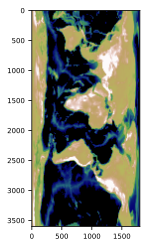

In [11]:
# If you want to check here
plt.imshow(np.flipud(elev),cmap='gist_earth',vmin=-4000,vmax=1500)

## Readjust the topography with dynamic topography and tectonic 

### Dynamic topography

In [12]:
dt0Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated/Interpolated_Y17-0.nc')


You can find and download dynamic topogaphy rasters in http://portal.gplates.org/portal/dt/

In [13]:
# Read the dynamic topography files and extract the values
dt0Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_0.00Ma.nc')
dt1Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_1.00Ma.nc')
dt2Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_2.00Ma.nc')
dt3Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_3.00Ma.nc')
dt4Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_4.00Ma.nc')
dt5Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_5.00Ma.nc')
dt6Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_6.00Ma.nc')
dt7Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_7.00Ma.nc')
dt8Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_8.00Ma.nc')
dt9Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_9.00Ma.nc')
dt10Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_10.00Ma.nc')
dt11Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_11.00Ma.nc')
dt12Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_12.00Ma.nc')
dt13Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_13.00Ma.nc')
dt14Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_14.00Ma.nc')
dt15Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_15.00Ma.nc')
dt16Ma = xr.open_dataset('../1-RefFrame/DynamicTopography/AY18/Interpolated-Y17_16.00Ma.nc')

dt0 = dt0Ma.Band1.values
dt1 = dt1Ma.Band1.values
dt2 = dt2Ma.Band1.values
dt3 = dt3Ma.Band1.values
dt4 = dt4Ma.Band1.values
dt5 = dt5Ma.Band1.values
dt6 = dt6Ma.Band1.values
dt7 = dt7Ma.Band1.values
dt8 = dt8Ma.Band1.values
dt9 = dt9Ma.Band1.values
dt10 = dt10Ma.Band1.values
dt11 = dt11Ma.Band1.values
dt12 = dt12Ma.Band1.values
dt13 = dt13Ma.Band1.values
dt14 = dt14Ma.Band1.values
dt15 = dt15Ma.Band1.values
dt16 = dt16Ma.Band1.values

dt0Maz = np.nan_to_num(dt0, copy=True, nan=0.0)
dt1Maz = np.nan_to_num(dt1, copy=True, nan=0.0)
dt2Maz = np.nan_to_num(dt2, copy=True, nan=0.0)
dt3Maz = np.nan_to_num(dt3, copy=True, nan=0.0)
dt4Maz = np.nan_to_num(dt4, copy=True, nan=0.0)
dt5Maz = np.nan_to_num(dt5, copy=True, nan=0.0)
dt6Maz = np.nan_to_num(dt6, copy=True, nan=0.0)
dt7Maz = np.nan_to_num(dt7, copy=True, nan=0.0)
dt8Maz = np.nan_to_num(dt8, copy=True, nan=0.0)
dt9Maz = np.nan_to_num(dt9, copy=True, nan=0.0)
dt10Maz = np.nan_to_num(dt10, copy=True, nan=0.0)
dt11Maz = np.nan_to_num(dt11, copy=True, nan=0.0)
dt12Maz = np.nan_to_num(dt12, copy=True, nan=0.0)
dt13Maz = np.nan_to_num(dt13, copy=True, nan=0.0)
dt14Maz = np.nan_to_num(dt14, copy=True, nan=0.0)
dt15Maz = np.nan_to_num(dt15, copy=True, nan=0.0)
dt16Maz = np.nan_to_num(dt16, copy=True, nan=0.0)


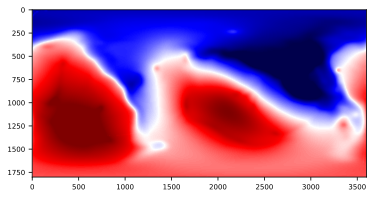

In [14]:
# If you want to check you dynamic topography values
plt.imshow(np.flipud(dt12Maz),cmap='seismic',vmin=-1000,vmax=1000)

### Sediment load

1- Here you can take the total sediment thickness into account to create the initial bathymetry 

In [15]:
# Load sediment thickness contours/or maps of sediment deposits from midMiocene to present day  
contour = "../contours_midMio-0.gpml"
featuresC = pygplates.FeatureCollection(contour)
filldataC = 0
valC = []
polyptsC = []
for feature in featuresC:
    stringC = feature.get_name()
    newstrC = stringC.replace("m", "")
    valC.append(int(newstrC))
    polyptsC.append(feature.get_geometry().to_lat_lon_array())
valC = np.asarray(valC)


In [16]:
# Readjust the format on regular mesh
latreg = np.linspace(-90,90,1801)
lonreg = np.linspace(-180,180,3601)
lonreg, latreg = np.meshgrid(lonreg, latreg)
ptsLonLatC = np.stack((latreg.flatten(), lonreg.flatten())).T
bathy = np.zeros(len(ptsLonLatC))

for k in range(len(polyptsC)):
    pathC = mpltPath.Path(polyptsC[k])
    insideC = pathC.contains_points(ptsLonLatC)
    idsC = np.where(insideC==True)[0]
    bathy[idsC] = valC[k]

bathy = bathy.reshape(lonreg.shape)

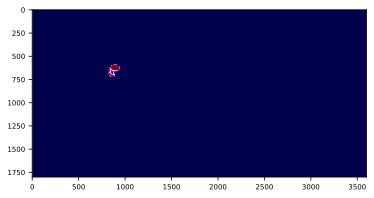

In [17]:
# To smooth your polygons and assign a percentage of subsidence
bathy1 = gaussian_filter((bathy), sigma=3.)*0.00 

# If you want to check the polygon values
plt.imshow(np.flipud(bathy),cmap='seismic',vmin=0,vmax=8000)

In [18]:
# Map on the mesh
mesh_bathy1 = ndimage.map_coordinates(bathy1, coord1, order=2, mode='nearest').astype(np.float64)


2- Remove the sediment thickness of the period you are investigating, here midMiocene deposits

In [19]:
# Load sediment thickness contours for the period you're investigating to remove then by subsidence
contour2 = "../contours_midMiocene.gpml.gpml"
featuresS = pygplates.FeatureCollection(contour2)
filldataS = 0
valS = []
polyptsS = []
for feature in featuresS:
    stringS = feature.get_name()
    newstrS = stringS.replace("m", "")
    valS.append(int(newstrS))
    polyptsS.append(feature.get_geometry().to_lat_lon_array())
valS = np.asarray(valS)


In [20]:
# Readjust the format on regular mesh
latreg = np.linspace(-90,90,1801)
lonreg = np.linspace(-180,180,3601)
lonreg, latreg = np.meshgrid(lonreg, latreg)
ptsLonLatS = np.stack((latreg.flatten(), lonreg.flatten())).T
subsidence = np.zeros(len(ptsLonLatS))

for k in range(len(polyptsS)):
    pathS = mpltPath.Path(polyptsS[k])
    insideS = pathS.contains_points(ptsLonLatS)
    idsS = np.where(insideS==True)[0]
    subsidence[idsS] = valS[k]

subsidence1 = (subsidence.reshape(lonreg.shape))*1

In [21]:
# If you want to smooth the polygons
subsi = gaussian_filter((subsidence1), sigma=3.)

sub=subsi*1.2

In [22]:
# Map values on the mesh
mesh_sub = ndimage.map_coordinates(sub, coord1, order=2, mode='nearest').astype(np.float64)


### Tectonic
Take the tectonic topography into account (map designed in GPlates)

In [23]:
# Load the tectonic polygons
vertical = "tectonic.gpml"
features0 = pygplates.FeatureCollection(vertical)
filldata0 = 0
val0 = []
polypts0 = []
for feature in features0:
    string0 = feature.get_name()
    newstr0 = string0.replace("m", "")
    val0.append(int(newstr0))
    polypts0.append(feature.get_geometry().to_lat_lon_array())
val0 = np.asarray(val0)


In [24]:
# Readjust the format on regular mesh
latreg = np.linspace(-90,90,1801)
lonreg = np.linspace(-180,180,3601)
lonreg, latreg = np.meshgrid(lonreg, latreg)
ptsLonLat0 = np.stack((latreg.flatten(), lonreg.flatten())).T
upsub = np.zeros(len(ptsLonLat0))

for k in range(len(polypts0)):
    path0 = mpltPath.Path(polypts0[k])
    inside0 = path0.contains_points(ptsLonLat0)
    ids0 = np.where(inside0==True)[0]
    upsub[ids0] = val0[k]

upsub = upsub.reshape(lonreg.shape)

# If you want to smooth your polygons
upsub = gaussian_filter((upsub), sigma=2)

# Map on the mesh
mesh_upsub = ndimage.map_coordinates(upsub, coord1, order=2, mode='nearest').astype(np.float64)


### Sum of the dynamic topography variation

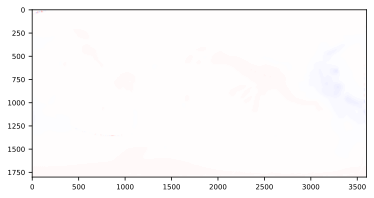

In [25]:
# Sum of dynamic topography variation 
dt_diff = (((dt15Maz-dt16Maz)*0.6)+(dt14Maz-dt15Maz)+(dt13Maz-dt14Maz)+(dt12Maz-dt13Maz)+(dt11Maz-dt12Maz)+(dt10Maz-dt11Maz)+(dt9Maz-dt10Maz)+(dt8Maz-dt9Maz)+(dt7Maz-dt8Maz)+(dt6Maz-dt7Maz)+(dt5Maz-dt6Maz)+(dt4Maz-dt5Maz)+(dt3Maz-dt4Maz)+(dt2Maz-dt3Maz)+(dt1Maz-dt2Maz)+(dt0Maz-dt1Maz)) #*1e6 if we want par Ma. 
cumdt_diff = ndimage.gaussian_filter(dt_diff.T,sigma=0.5)
cumdt_diff = np.nan_to_num(cumdt_diff)

# If you want to check
test = dt15Maz-dt16Maz
plt.imshow(np.flipud(test),cmap='seismic',vmin=test.min(),vmax=test.max())


In [26]:
# Remove the dynamic topography variation from Etopo01
ini_elev=elev-cumdt_diff

# Map on the mesh
meshZ = ndimage.map_coordinates(ini_elev, coord1, order=2, mode='nearest').astype(np.float64)
cumDT = ndimage.map_coordinates(cumdt_diff, coord1, order=2, mode='nearest').astype(np.float64)


### Readjust the initial topography 

In [27]:
# Readjust the initial topography using polygons in GPlates
Topo_adjust = "topo_readjustement.gpml"
features_adjust = pygplates.FeatureCollection(Topo_adjust)
filldata_adjust = 0
val_adjust = []
polypts_adjust = []
for feature in features_adjust:
    string_adjust = feature.get_name()
    newstr_adjust = string_adjust.replace("m", "")
    val_adjust.append(int(newstr_adjust))
    polypts_adjust.append(feature.get_geometry().to_lat_lon_array())
val_adjust = np.asarray(val_adjust)


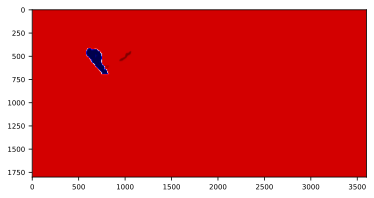

In [28]:
# Readjust the format on regular mesh
latreg = np.linspace(-90,90,1801)
lonreg = np.linspace(-180,180,3601)
lonreg, latreg = np.meshgrid(lonreg, latreg)
ptsLonLat2 = np.stack((latreg.flatten(), lonreg.flatten())).T
tectoZ = np.zeros(len(ptsLonLat2))

for k in range(len(polypts_adjust)):
    path2 = mpltPath.Path(polypts_adjust[k])
    inside2 = path2.contains_points(ptsLonLat2)
    ids2 = np.where(inside2==True)[0]
    tectoZ[ids2] = val_adjust[k]

tectoZ = tectoZ.reshape(lonreg.shape)

# If you want to smooth the polygons
tectoZ = gaussian_filter((tectoZ), sigma=2)

# If you want to check the polygons
plt.imshow(np.flipud(tectoZ),cmap='seismic',vmin=tectoZ.min(),vmax=tectoZ.max())

# Map on the mesh
mesh_tectoZ = ndimage.map_coordinates(tectoZ, coord1, order=2, mode='nearest').astype(np.float64)


In [29]:
# Print data on the mesh for visualisation
vis_mesh = meshio.Mesh(coords, {'triangle': grid.simplices}, point_data={"z":meshZ, "dt":cumDT})
meshio.write('globalData.vtk', vis_mesh)

np.savez_compressed(dir_lvl+'/globMesh', v=coords, c=grid.simplices, 
                    n=ngbID[:,:8].astype(int), z=meshZ)

# 3- Create the tectonic files

### Create individual 3D dynamic topography files

In [30]:
# Create the tectonic files
t15 = ((dt15Maz-dt16Maz)*0.6)
t14 = ((dt14Maz-dt15Maz))
t13 = ((dt13Maz-dt14Maz))
t12 = ((dt12Maz-dt13Maz))

tec15 = ndimage.gaussian_filter(t15.T,sigma=0.8)
tec14 = ndimage.gaussian_filter(t14.T,sigma=0.8)
tec13 = ndimage.gaussian_filter(t13.T,sigma=0.8)
tec12 = ndimage.gaussian_filter(t12.T,sigma=0.8)

tec15 = np.nan_to_num(tec15)
tec14 = np.nan_to_num(tec14)
tec13 = np.nan_to_num(tec13)
tec12 = np.nan_to_num(tec12)

In [31]:
# Map mesh coordinates on this dataset
londt = tec15.shape[0] * glon / 360.0
latdt = tec15.shape[1] * glat / 180.0
coord_dt = np.stack((londt, latdt))

mesh_dt15 = ndimage.map_coordinates(tec15, coord_dt, order=2, mode='nearest').astype(np.float64)
mesh_dt14 = ndimage.map_coordinates(tec14, coord_dt, order=2, mode='nearest').astype(np.float64)
mesh_dt13 = ndimage.map_coordinates(tec13, coord_dt, order=2, mode='nearest').astype(np.float64)
mesh_dt12 = ndimage.map_coordinates(tec12, coord_dt, order=2, mode='nearest').astype(np.float64)

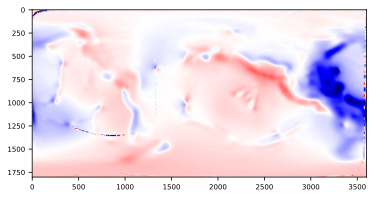

In [32]:
# If you want to check
plt.imshow(np.flipud(tec13.T),cmap='seismic',vmin=-50,vmax=50)

In [33]:
# Set tectonic file name
npztecto15 = os.path.join(dir_lvl, "tectoDT15Y17_bathy000_sub05")
npztecto14 = os.path.join(dir_lvl, "tectoDT14Y17_bathy000_sub05")
npztecto13 = os.path.join(dir_lvl, "tectoDT13Y17_bathy000_sub05")
npztecto12 = os.path.join(dir_lvl, "tectoDT12Y17_bathy000_sub05")

# Save the tectonic as compressed numpy file for gospl
np.savez_compressed(npztecto15, z=mesh_dt15)
np.savez_compressed(npztecto14, z=mesh_dt14)
np.savez_compressed(npztecto13, z=mesh_dt13)
np.savez_compressed(npztecto12, z=mesh_dt12)

# 4- Create a local 2D mesh

In [34]:
lat2D = np.linspace(0,180,4501)
lon2D = np.linspace(0,360,9001)
lon, lat = np.meshgrid(lon2D, lat2D)

In [35]:
# Map mesh coordinates on the dataset Etopo01
lon1 = ini_elev.shape[0] * lon.flatten() / 360.0
lat1 = ini_elev.shape[1] * lat.flatten() / 180.0
coord1 = np.stack((lon1, lat1))

mesh_elev = ndimage.map_coordinates(ini_elev, coord1, order=2, mode='nearest').astype(np.float64)

In [36]:
# Map mesh coordinates on the dynamic topography dataset
lon2 = cumdt_diff.shape[0] * lon.flatten() / 360.0
lat2 = cumdt_diff.shape[1] * lat.flatten() / 180.0
coord2 = np.stack((lon2, lat2))

mesh_cumdt = ndimage.map_coordinates(cumdt_diff, coord2, order=2, mode='nearest').astype(np.float64)

In [37]:
# Map mesh coordinates on the tectonic readjustment dataset 
lon3 = tectoZ.shape[1] * lon.flatten() / 360
lat3 = tectoZ.shape[0] * lat.flatten() / 180
coord3 = np.stack((lat3,lon3))

mesh_tecto = ndimage.map_coordinates(tectoZ, coord3, order=2, mode='nearest').astype(np.float64)

In [38]:
# Map mesh coordinates on the bathymetry "subsidence" dataset
lon4 = bathy1.shape[1] * lon.flatten() / 360
lat4 = bathy1.shape[0] * lat.flatten() / 180
coord4 = np.stack((lat4,lon4))

mesh_bathy = ndimage.map_coordinates(bathy1, coord4, order=2, mode='nearest').astype(np.float64)


In [39]:
# Map mesh coordinates on the tectonic dataset 
lon5 = upsub.shape[1] * lon.flatten() / 360
lat5 = upsub.shape[0] * lat.flatten() / 180
coord5 = np.stack((lat5,lon5))

mesh_upsub = ndimage.map_coordinates(upsub, coord5, order=2, mode='nearest').astype(np.float64)


In [40]:
# Map mesh coordinates on the dataset containing the subsidence induced by the midMiocene sediment 
lon6 = sub.shape[1] * lon.flatten() / 360
lat6 = sub.shape[0] * lat.flatten() / 180
coord6 = np.stack((lat6,lon6))

mesh_sub = ndimage.map_coordinates(sub, coord6, order=2, mode='nearest').astype(np.float64)

In [44]:
# reshape data with the 2D mesh
zz = mesh_elev.reshape(lon.shape) # etopo reshape
dt = mesh_cumdt.reshape(lon.shape) # dynamic topography reshape
tt = mesh_tecto.reshape(lon.shape) # tectonic reshape
uu = mesh_upsub.reshape(lon.shape) # uplift/subsidence reshape
bb = mesh_bathy.reshape(lon.shape) # sediment thickness contours MIDDLE MIO TO PRESNT
su = mesh_sub.reshape(lon.shape) # uplift/subsidence reshape MID MIO

In [45]:
# Define the extension of the 2D model
llcrnrlon = -120 # Lower left corner longitude
llcrnrlat = 15 # Lower left corner latitude
urcrnrlon = -71  # Upper right corner longitude
urcrnrlat = 42 # Upper right corner latitude

In [46]:
# Find ids in the model's box
id1 = np.where(lon[0,:]-180 == llcrnrlon)[0][0], np.where(lon[0,:]-180 == urcrnrlon)[0][0]
id2 = np.where(lat[:,0]-90 == llcrnrlat)[0][0], np.where(lat[:,0]-90 == urcrnrlat)[0][0]

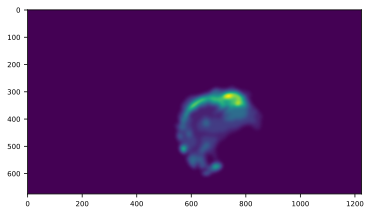

In [47]:
# Define the values in box
zbox = zz[id2[0]:id2[1],id1[0]:id1[1]] 
dtbox = dt[id2[0]:id2[1],id1[0]:id1[1]] 
ttbox = tt[id2[0]:id2[1],id1[0]:id1[1]] 
uubox = uu[id2[0]:id2[1],id1[0]:id1[1]] 
bbbox = bb[id2[0]:id2[1],id1[0]:id1[1]] 
subox = su[id2[0]:id2[1],id1[0]:id1[1]]  

# Check the 2D extentions
plt.imshow(np.flipud(subox))

In [48]:
bblon = lon[id2[0]:id2[1],id1[0]:id1[1]]-180.
bblat = lat[id2[0]:id2[1],id1[0]:id1[1]]-90.

In [49]:
# Project the values on the mesh
offset = 0.1
lonMin = llcrnrlon 
latMin = llcrnrlat
lonMax = urcrnrlon
latMax = urcrnrlat

if lonMin < 0 and lonMax < 0:
    lon_0 = -(abs( lonMax ) + abs( lonMin )) / 2.0
else:
    lon_0 = (abs( lonMax ) + abs( lonMin )) / 2.0

map = Basemap(llcrnrlat = latMin, urcrnrlat = latMax,\
                llcrnrlon = lonMin, urcrnrlon = lonMax,\
                resolution = 'h', area_thresh = 10., projection = 'merc',\
                lat_1 = latMin, lon_0 = lon_0)

### Define the new initial topography

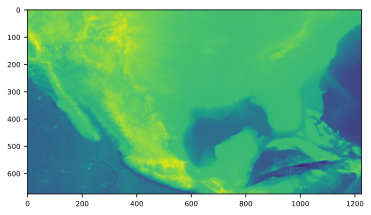

In [50]:
# Remove the tectonic and sediment impact from the initial topography
utmx, utmy = map(bblon, bblat)
paleogeography = (zbox+ttbox-bbbox) 

# Smooth the obtained elevation
smthz = gaussian_filter(paleogeography, sigma=0.2)

# If you want to check
plt.imshow(np.flipud(paleogeography))

In [51]:
coord1 = np.vstack([utmx.ravel(), utmy.ravel()])
coord1 = np.vstack([coord1, smthz.ravel()]).T

In [52]:
cloudPts = pv.PolyData(coord1)
surface = cloudPts.delaunay_2d()
faces = surface.faces.reshape((-1,4))[:, 1:4]

### Create the 2D files

In [53]:
# Print data on the local mesh for visualisation
vis_mesh = meshio.Mesh(coord1, {"triangle": faces},
                        point_data={"elevation": coord1[:,2]})
meshio.write('mesh2D.vtk', vis_mesh)

In [54]:
# Vizualise the new
mesh = pv.read('mesh2D.vtk')

new_paleogeography = mesh.get_array(name='elevation')
scale = 100.
mesh.points[:, 2] *= scale
contour = mesh.contour([0])

plotter = pv.PlotterITK()
plotter.add_mesh(mesh, scalars="elevation")
plotter.add_mesh(contour, color="black", opacity=1.)

plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [55]:
# Set meshplex triangular mesh
Gmesh = meshplex.MeshTri(coord1, faces)
s = Gmesh.idx_hierarchy.shape
a = np.sort(Gmesh.idx_hierarchy.reshape(s[0], -1).T)
Gmesh.edges = {"points": np.unique(a, axis=0)}

# Get each vertice neighbours indices
_, Ngbs = definegtin(len(coord1), faces, Gmesh.edges["points"])

# Remove small pits (below 10 m depth) 
fillz = gfill(-3000., coord1[:,2], Ngbs, 10.)

In [56]:
# Set local elevation file name
lpoints = coord1.copy()
lpoints[:,2]=0.

elevfname = dir_lvl+"/mesh2D"
np.savez_compressed(elevfname, v=lpoints, c=faces, 
                    n=Ngbs[:, :8].astype(int), z=fillz)

# 5- Define the 2D tectonic files

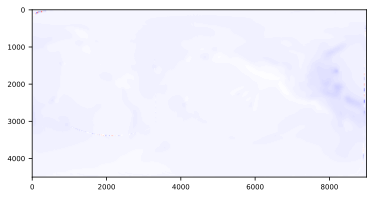

In [57]:
# Map mesh coordinates on this dataset
lon_dt = tec15.shape[0] * lon.flatten() / 360.0
lat_dt = tec15.shape[1] * lat.flatten() / 180.0
coordDT = np.stack((lon_dt, lat_dt))

meshd15 = ndimage.map_coordinates(tec15, coordDT, order=2, mode='nearest').astype(np.float64)
meshd14 = ndimage.map_coordinates(tec14, coordDT, order=2, mode='nearest').astype(np.float64)
meshd13 = ndimage.map_coordinates(tec13, coordDT, order=2, mode='nearest').astype(np.float64)
meshd12 = ndimage.map_coordinates(tec12, coordDT, order=2, mode='nearest').astype(np.float64)

tt15 = meshd15.reshape(lon.shape)# dt
tt14 = meshd14.reshape(lon.shape)# dt
tt13 = meshd13.reshape(lon.shape)# dt
tt12 = meshd12.reshape(lon.shape)# dt

# If you want to check
plt.imshow(np.flipud(tt15),cmap='seismic',vmin=tt15.min(),vmax=tt15.max())

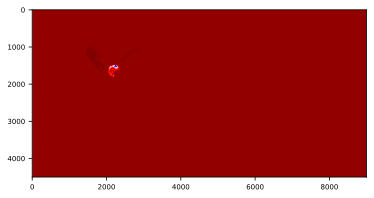

In [59]:
# add Dt impact and uplift subsidence
tt15 = ((tt15+uu)/1000000)+(-su/6000000)
tt14 = ((tt14+uu)/1000000)+(-su/6000000)
tt13 = ((tt13+uu)/1000000)+(-su/6000000)
tt12 = ((tt12+uu)/1000000)+(-su/6000000)

# If you want to check
plt.imshow(np.flipud(tt15),cmap='seismic',vmin=tt15.min(),vmax=tt15.max())

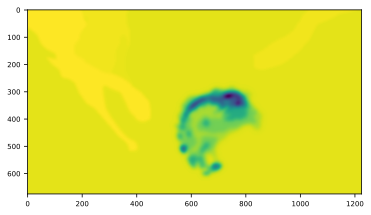

In [60]:
# Redefine the extension of the model
ttbox15 = tt15[id2[0]:id2[1],id1[0]:id1[1]] 
ttbox14 = tt14[id2[0]:id2[1],id1[0]:id1[1]] 
ttbox13 = tt13[id2[0]:id2[1],id1[0]:id1[1]] 
ttbox12 = tt12[id2[0]:id2[1],id1[0]:id1[1]] 

# If you want to check
plt.imshow(np.flipud(ttbox15))

In [61]:
# Print data on the local mesh for visualisation
coord15 = np.vstack([utmx.ravel(), utmy.ravel()])
coord15 = np.vstack([coord15, ttbox15.ravel()]).T
coord14 = np.vstack([utmx.ravel(), utmy.ravel()])
coord14 = np.vstack([coord14, ttbox14.ravel()]).T
coord13 = np.vstack([utmx.ravel(), utmy.ravel()])
coord13 = np.vstack([coord13, ttbox13.ravel()]).T
coord12 = np.vstack([utmx.ravel(), utmy.ravel()])
coord12 = np.vstack([coord12, ttbox12.ravel()]).T

vis_mesh = meshio.Mesh(coord12, {"triangle": faces},
                        point_data={"tecto2": coord12[:,2]/1000})
meshio.write('mesh2Dtecto.vtk', vis_mesh)

In [62]:
# Set tectonic file name
npztecto15 = os.path.join(dir_lvl, "2DtectoDT15")
npztecto14 = os.path.join(dir_lvl, "2DtectoDT14")
npztecto13 = os.path.join(dir_lvl, "2DtectoDT13")
npztecto12 = os.path.join(dir_lvl, "2DtectoDT12")

# Save the tectonic as compressed numpy file for gospl
np.savez_compressed(npztecto15, z=coord15[:,2])
np.savez_compressed(npztecto14, z=coord14[:,2])
np.savez_compressed(npztecto13, z=coord13[:,2])
np.savez_compressed(npztecto12, z=coord12[:,2])

# 6- Readjust the topography with the paleo-drainage

## Here we use the Snedden paleo-drainage

In [63]:
# Load your river's file. Always plot the rivers from the rivermouth to source.
paleofile = "rivers.gpml"
features = pygplates.FeatureCollection(paleofile)

val = []
polypts = []
for feature in features:
    string = feature.get_name()
    polypts.append(feature.get_geometry().to_lat_lon_array())

nb = 0
path = []
for k in range(len(polypts)):
    path.append(mpltPath.Path(polypts[k]).vertices)
    nb += len(path[-1]) 

In [ ]:
# (mpltPath.Path(polypts[k]).vertices)

In [64]:
# Extract the ID, latitude and longitude of the river's points
data = np.zeros((nb,3))

stp = 0
for k in range(len(polypts)):
    lnb = len(path[k])
    data[stp:stp+lnb,0] = k
    data[stp:stp+lnb,1] = path[k][:,0]
    data[stp:stp+lnb,2] = path[k][:,1]
    stp += lnb 

In [65]:
# Store all the river trunks in a csv file
paleox, paleoy = map(data[:,2], data[:,1])
paleodata = pd.DataFrame({'nb':data[:,0],'lat':data[:,1],'lon':data[:,2], 'x': paleox, 'y': paleoy})
paleodata.to_csv('drainage.csv',columns=['nb','x', 'y', 'lat'], sep=',', index=False ,header=1)


### Reorganise each river from mouth to headwaters

This is easier if the digitalisation is done from river mouth to headwaters initially.

In [66]:
trunk = -np.ones(len(data))
trunkID = []

trunkID.append([0,1,2,3,4,5])
trunkID.append([0,1,2,3,4,8])
trunkID.append([0,1,2,3,7])
trunkID.append([0,1,2,6])

trunkID.append([0,1,9,10,11,12])
trunkID.append([0,1,9,10,11,17])
trunkID.append([0,1,9,10,14,15])
trunkID.append([0,1,9,10,14,16])
trunkID.append([0,1,9,13])

trunkID.append([18,19,20,21,22,23])
trunkID.append([18,19,20,21,22,26])
trunkID.append([18,19,20,21,25])
trunkID.append([18,19,20,24])

trunkID.append([18,19,27,28,29,30])
trunkID.append([18,19,27,28,29,33])
trunkID.append([18,19,27,28,32])
trunkID.append([18,19,27,31])

trunkID.append([34,35,36,37,38,42,43])
trunkID.append([34,35,36,37,38,42,44])
trunkID.append([34,35,36,37,38,39])
trunkID.append([34,35,36,37,41])
trunkID.append([34,35,36,40])

trunkID.append([34,35,45,46,47])
trunkID.append([34,35,45,46,49])
trunkID.append([34,35,45,48])

rivID = []
rivDF = []
intDF = []

meshtree = spatial.cKDTree(coord1[:,:2], leafsize=10)

for k in range(len(trunkID)):
    
    # Combine each trunk to form the main paleo-rivers
    for p in range(len(trunkID[k])):
        ids = data[:,0] == trunkID[k][p]
        trunk[ids] = k
    
    id = np.where(trunk==k)[0]
    rivID.append(id)
    rivDF.append(pd.DataFrame({'lat':data[id,1],'lon':data[id,2], 
                               'x': paleox[id], 'y': paleoy[id]}))

    # Order from mouth to headwaters
    exist = np.ones(len(id),dtype=bool)
    mouthID = rivDF[-1].lat.argmin()
    criv = np.vstack((rivDF[-1].x,rivDF[-1].y)).T
    tree = spatial.cKDTree(criv)

    order = []
    order.append(mouthID)
    for k in range(1, len(rivDF[-1].x)):
        id = order[-1] 
        exist[id] = False
        pos = [rivDF[-1].x[id],rivDF[-1].y[id]]
        d, n = tree.query(pos, k=10)
        for p in range(10):
            if exist[n[p]] == True:
                id = n[p]
                break
        order.append(id)
        
    rivorder = np.zeros(len(rivDF[-1].x))
    for k in range(0, len(rivDF[-1].x)):
        rivorder[order[k]] = k
    
    rivDF[-1]['order'] = rivorder
    rivDF[-1] = rivDF[-1].sort_values(by='order').reset_index(drop=True)
    
    # Create more points along each trunk (250 m interval)
    xy = []
    for p in range(len(rivDF[-1].x)-1):
        ls = LineString([(rivDF[-1].x[p], rivDF[-1].y[p]), 
                         (rivDF[-1].x[p+1], rivDF[-1].y[p+1])])
        for f in range(0, int(math.ceil(ls.length)) + 1, 250):
            p = ls.interpolate(f).coords[0]
            xy.append((p[0],p[1]))
    xx = np.array(xy, 'i')
    nx = xx[:,0]
    ny = xx[:,1]
    
    ds = np.zeros(len(nx))
    for k in range(1,len(nx)):
        ds[k] = ((nx[k]-nx[k-1])**2+(ny[k]-ny[k-1])**2)**0.5
        ds[k] += ds[k-1]
    
    # Get elevation on each of these trunks based on initial topography
    rivcoords = np.zeros((len(nx),2))
    rivcoords[:,0] = nx
    rivcoords[:,1] = ny
    dist, idd = meshtree.query(rivcoords, k=4)
    # Inverse weighting distance...
    weights = np.divide(
        1.0, dist, out=np.zeros_like(dist), where=dist != 0
    )
    onIDs = np.where(dist[:, 0] == 0)[0]
    temp = np.sum(weights, axis=1)
    tmp = np.sum(weights * coord1[idd, 2], axis=1)
    nelev = np.divide(tmp, temp, out=np.zeros_like(temp), where=temp != 0)
    
    if len(onIDs) > 0:
        nelev[onIDs] = coord1[idd[onIDs, 0], 2]
    
    # Ensure downstream flow, you can define different slopes
    distx = ds[::-1]
    rivh = nelev[::-1]
    newh = np.zeros(len(distx))
    slp = -1.e-6
    slp2 = -1.e-6
    newh[0] = rivh[0]
    
    
    for k in range(1,len(distx)):
        dh = slp*(distx[k-1]-distx[k])
        dh2 = slp2*(distx[k-1]-distx[k])
        altmax = 200
        
        if rivh[k] > altmax:
            if rivh[k] < newh[k-1]+dh:
                newh[k] = rivh[k]
            else:
                newh[k] = newh[k-1]+dh
        else:
            if rivh[k] < newh[k-1]+dh2:
                newh[k] = rivh[k]
            else:
                newh[k] = newh[k-1]+dh2
                
    datafm = pd.DataFrame({'x': nx, 
                               'y': ny, 
                               'h': nelev, 
                               'd': ds,
                               'nh': newh[::-1],
                               'o': np.arange(len(nx))})
    
    datafm = datafm[datafm.h > 0]
    intDF.append(datafm.reset_index())
    
for k in range(len(trunkID)):
    intDF[k].to_csv('riv'+str(k+1)+'.csv',columns=['x', 'y', 'h', 'nh', 'd','o'], 
                    sep=',', index=False ,header=1)

### Plot the initial and the modified river

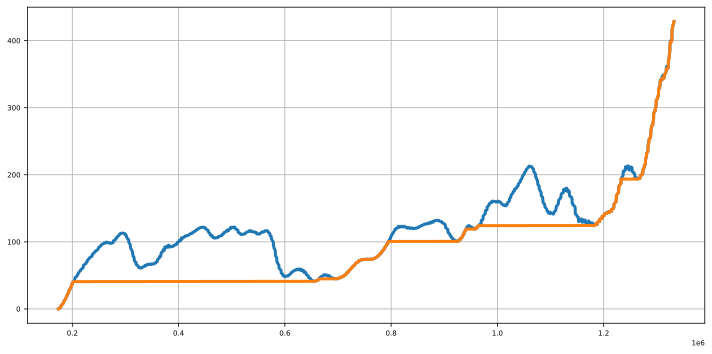

In [68]:
plt.figure(figsize=(10,5))
ax = plt.gca()

# You can change the river ID here
river = 12
plt.plot(intDF[river].d, intDF[river].h, lw=3)
plt.plot(intDF[river].d, intDF[river].nh, lw=3)

plt.grid()
plt.tight_layout()
plt.show()

### Create valleys to force rivers

In [69]:
meshtree = spatial.cKDTree(coord1[:,:2], leafsize=10)
felev = fillz.copy()

for k in range(len(intDF)):

    rivX = intDF[k].x
    rivY = intDF[k].y
    rivZ = intDF[k].nh # you can modify the value - (intDF[k].nh)/6 
    rivZ2 = np.where((rivZ>275),(rivZ -(intDF[k].nh)/10),(rivZ-(intDF[k].nh)/2))
    # modify how you want to incise the valleys                 
                     
    coordsRiv = np.vstack((rivX,rivY)).T
    ids = meshtree.query_ball_point(coordsRiv, r=12000) # you can modify r the wideness of the river, here 10 km 

    for p in range(len(ids)):
        felev[ids[p]] = np.minimum(felev[ids[p]],rivZ2[p])

In [71]:
# You can smooth the river and elevation
smthfz = gaussian_filter(fillz.reshape(utmx.shape), sigma=1.2)# all elevation
smthfz2 = gaussian_filter(felev.reshape(utmx.shape), sigma=1.2)# rivers corrected


In [73]:
iii = np.where(smthfz>smthfz2)

digZ = fillz.reshape(utmx.shape).copy()

digZ[iii] = smthfz2[iii]

neww = np.minimum(digZ.ravel(),fillz)

In [74]:
# Remove small pits (below 5 m depth) from -3000.0 m depth to top of the surface
fillz2 = gfill(-3000., neww, Ngbs, 50.)   # 10 = si plus de 10 mettre, arete de fill : si un trou qui fais plus de 10 metres, il va s'arreter. essayer 500,... jouer sur smoothing , essayer -500 au lieu de 3000 Attention, si on fill trop, du coup les rivieres ne vont plus passer dans les valees. Aussi jouer sur le 10 km wide, essayer le 20 km 
fillz2[fillz2>fillz] =fillz[fillz2>fillz] 


In [75]:
# Print data on the local mesh for visualisation
ncoords = coord1.copy()
ncoords[:,2] = fillz2
vis_mesh = meshio.Mesh(ncoords, {"triangle": faces},
                        point_data={"elev": fillz2,"diff": (fillz-fillz2).ravel()})
meshio.write('river.vtk', vis_mesh)

In [76]:
# Set global elevation file name
elevfname = dir_lvl+"/mesh2Driver"
np.savez_compressed(elevfname, v=lpoints, c=faces, 
                    n=Ngbs[:, :8].astype(int), z=fillz2)

# 7- Readjust the topography with coastline

In [77]:
paleofile = "coastline.gpml"
features = pygplates.FeatureCollection(paleofile)

# Read polygon values
val = []
polypts = []
for feature in features:
    string = feature.get_name()
    polypts.append(feature.get_geometry().to_lat_lon_array())

nb = 0
path = []
for k in range(len(polypts)):
    path.append(mpltPath.Path(polypts[k]).vertices)
    nb += len(path[-1]) 

data = np.zeros((nb+1,3))
stp = 0
for k in range(len(polypts)):
    lnb = len(path[k])
    data[stp:stp+lnb,0] = k
    data[stp:stp+lnb,1] = path[k][:,0]
    data[stp:stp+lnb,2] = path[k][:,1]
    stp += lnb 

data[-1,:] = data[0,:]

# Transform from lon lat to utm
paleox, paleoy = map(data[:,2], data[:,1])

# Save as dataframe
paleocoast = pd.DataFrame({'lat':data[:,1],'lon':data[:,2], 'x': paleox, 'y': paleoy})

In [78]:
# Create more points along the coastline (250 m interval)
xy = []
for p in range(len(paleocoast.x)-1):
    ls = LineString([(paleocoast.x[p], paleocoast.y[p]), 
                     (paleocoast.x[p+1], paleocoast.y[p+1])])
    for f in range(0, int(math.ceil(ls.length)) + 1, 250):
        p = ls.interpolate(f).coords[0]
        xy.append((p[0],p[1]))
xx = np.array(xy)
nx = xx[:,0]
ny = xx[:,1]

# Save as dataframe and in a file
paleocoastline = pd.DataFrame({'x': nx, 'y': ny, 'id':np.arange(len(nx))})
paleocoastline.to_csv('coastlineSnedden.csv',columns=['x', 'y', 'id'], sep=',', index=False ,header=1)

In [79]:
# Check if a point is within the coastline polygon

@jit(nopython=True)
def is_inside_sm(polygon, point):
    length = len(polygon)-1
    dy2 = point[1] - polygon[0][1]
    intersections = 0
    ii = 0
    jj = 1

    while ii<length:
        dy  = dy2
        dy2 = point[1] - polygon[jj][1]

        # consider only lines which are not completely above/bellow/right from the point
        if dy*dy2 <= 0.0 and (point[0] >= polygon[ii][0] or point[0] >= polygon[jj][0]):

            # non-horizontal line
            if dy<0 or dy2<0:
                F = dy*(polygon[jj][0] - polygon[ii][0])/(dy-dy2) + polygon[ii][0]

                if point[0] > F: # if line is left from the point - the ray moving towards left, will intersect it
                    intersections += 1
                elif point[0] == F: # point on line
                    return 2

            # point on upper peak (dy2=dx2=0) or horizontal line (dy=dy2=0 and dx*dx2<=0)
            elif dy2==0 and (point[0]==polygon[jj][0] or (dy==0 and (point[0]-polygon[ii][0])*(point[0]-polygon[jj][0])<=0)):
                return 2

        ii = jj
        jj += 1

    #print 'intersections =', intersections
    return intersections & 1  


@njit(parallel=True)
def is_inside_sm_parallel(points, polygon):
    ln = len(points)
    D = np.empty(ln, dtype=numba.boolean) 
    for i in numba.prange(ln):
        D[i] = is_inside_sm(polygon,points[i])
    return D  

In [80]:
inside = is_inside_sm_parallel(coord1,xx)

In [81]:
# Build a tree with the coordinates of the coastline
coastTree = spatial.cKDTree(xx, leafsize=10)

# Get the point that are below sealevel par rapport a la coastline uniquement 
asl = np.where(inside+0>=1)[0] # points above coastline
bsl = np.where(inside+0<1)[0] # points below coastline

# inland = np.where(asl)
distanceMar = np.zeros(len(coord1))

# Find the distance of the 2D mesh to the coastline
dist, ids = coastTree.query(coord1[bsl,:2], k=1)
distanceMar[bsl] = dist
distanceLand = np.zeros(len(coord1))

# Find the distance of the 2D mesh to the coastline
dist, ids = coastTree.query(coord1[asl,:2], k=1)
distanceLand[asl] = dist
distance2coast = np.zeros(len(coord1))

# Find the distance of the 2D mesh to the coastline
dist, ids = coastTree.query(coord1[bsl,:2], k=1)
distance2coast[bsl] = dist

In [82]:
minhLand = 1.e-6*distanceLand
minhMarin = -1.e-6*distanceMar

In [83]:
nelev = fillz2.copy()

# Give an elevation depending on the distance to the coast
aboveZ = nelev[asl]
minH = minhLand[asl]
id = np.where(aboveZ<minH)[0]
aboveZ[id] = minH[id]
nelev[asl] = aboveZ

belowZ = nelev[bsl]
minH = minhMarin[bsl]
id = np.where(belowZ>minH)[0]
belowZ[id] = minH[id]
nelev[bsl] = belowZ

dz = nelev-fillz2

In [84]:
# Print data on the local mesh for visualisation
vis_mesh = meshio.Mesh(ncoords, {"triangle": faces},
                        point_data={"elev": nelev,"dz": nelev-fillz2,"dist": distance2coast})
meshio.write('iniElevation.vtk', vis_mesh)

In [85]:
# Set global elevation file name
elevfname = dir_lvl+"/iniElevation"
np.savez_compressed(elevfname, v=lpoints, c=faces, 
                    n=Ngbs[:, :8].astype(int), z=nelev)